## Model Tuning and Performance Plotting
This notebook covers the usage of the <code>model.train_test_batch()</code>  function, and the interpretation of its results. Given a range of parameters and a model class, all parameter combinations are trained and their performance assessed. The models are also saved.

The only necessary import is the AE model.

In [23]:
from FlowCompression import AE

Various parameter options exist for the AE. Here, the number of epochs and the network structure are varied. Number of epochs is kept minimal for demonstration.

In [24]:
param_ranges_dict = {'l_rate': [0.1],
                         'epochs': [5, 10],
                         'batch': [10],
                         'early_stopping': [3],
                         'dimensions': [[8, 4, 2, 1], [16, 8, 4, 2]]}

<code>model.train_test_batch()</code> takes a model argument (only AE implemented) and a parameter dictionairy as above, with the option to save the model.

In [25]:
AE.train_test_batch(param_ranges_dict, AE, save=False)

Epoch 1/5
300/300 [==============================] - 8s 22ms/step - loss: 0.3025 - val_loss: 0.0211
Epoch 2/5
300/300 [==============================] - 6s 21ms/step - loss: 0.0240 - val_loss: 0.0252
Epoch 3/5
300/300 [==============================] - 7s 22ms/step - loss: 0.0328 - val_loss: 0.0208
Epoch 4/5
300/300 [==============================] - 8s 26ms/step - loss: 0.0273 - val_loss: 0.0215
Epoch 5/5
300/300 [==============================] - 7s 23ms/step - loss: 0.0273 - val_loss: 0.0205
AE 0 tuned
Epoch 1/10
300/300 [==============================] - 11s 33ms/step - loss: 0.1474 - val_loss: 0.0208
Epoch 2/10
300/300 [==============================] - 8s 27ms/step - loss: 0.0329 - val_loss: 0.0531
Epoch 3/10
300/300 [==============================] - 7s 23ms/step - loss: 0.0432 - val_loss: 0.0324
Epoch 4/10
300/300 [==============================] - 6s 20ms/step - loss: 0.0597 - val_loss: 0.0625
AE 1 tuned
Epoch 1/5
300/300 [==============================] - 8s 21ms/step - loss:

Model performance and (optionally) the model itself are saved in the FlowCompression module. The default directories are <code>FlowCompression\TuningDivision\Raw</code> and <code>FlowCompression\KerasModels\Raw</code> by default. Note that the models above were not saved.

For instruction on loading models see the AE notebook.

Model performance is saved as a <code>.csv</code> file saving the parameters of the model and a set of performance measures from the <code>Model.performance()</code> function.

The <code>.csv</code> is loaded as below. As the POD and AE file structures are subtly different, both are given.

#### AE

In [30]:
import os
from csv import reader

path = os.path.join('FlowCompression', 'TuningDivision', 'AE_0.95.csv')
with open(path, newline='')\
        as csvfile:
    rows = reader(csvfile, delimiter=',')
    data_AE = {
        'n': [],
        'mse': [],
        'abs_mean': [],
        'sqr_mean': [],
        'div_max': [],
        'div_min': [],
        'div_avg': []
    }
    flag = False
    for row in rows:
        if flag:
            mse, abs_mean, _, sqr_mean, _, div_max, div_min, div_avg, _, dim, _, _, _ = row
            n = dim.strip('][').split(', ')[3]
            lst = [float(n), float(mse), float(abs_mean), float(sqr_mean), float(div_max), float(div_min),
                   float(div_avg)]
            i = 0
            for key in data_AE.keys():
                data_AE[key].append(lst[i])
                i += 1

        if not flag:
            flag = True

#### POD

In [31]:
path = os.path.join('FlowCompression', 'TuningDivision', 'POD_0.95.csv')
with open(path, newline='')\
        as csvfile:
    rows = reader(csvfile, delimiter=',')
    data_POD = {
        'n': [],
        'mse': [],
        'abs_mean': [],
        'sqr_mean': [],
        'div_max': [],
        'div_min': [],
        'div_avg': []
    }
    flag = False
    for row in rows:
        if flag:
            mse, _, abs_mean, _, sqr_mean, _, _, div_max, div_min, div_avg, n = row
            if n == 'n':
                raise Exception('Duplicate data in file. Delete file and run generate 1 time to fix')
            lst = [float(n), float(mse), float(abs_mean), float(sqr_mean), float(div_max), float(div_min),
                   float(div_avg)]
            i = 0
            for key in data_POD.keys():
                data_POD[key].append(lst[i])
                i += 1

        if not flag:
            flag = True

What the code snippets above did is extract data into a dictionairy (<code>data_AE</code> and <code>data_POD</code>). You can do whatever you want with this dictionairy, for us it was particularly pertinent to explore performance as a function of latent space dimension.

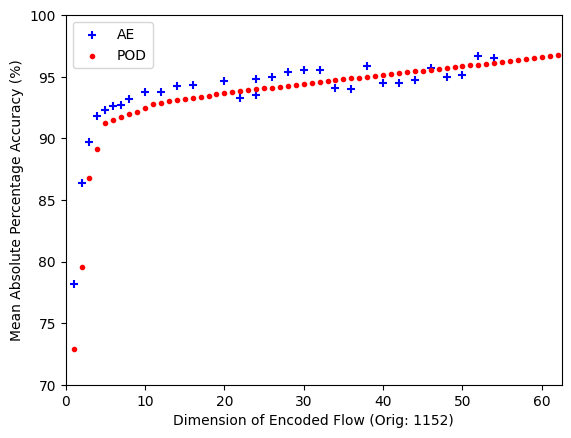

In [32]:
import matplotlib.pyplot as plt

data = {'AE': data_AE,
        'POD': data_POD}

for key in data_POD:
    if key != 'n':
        for label in ['AE', 'POD']:
            if label == 'AE':
                color = 'b'
                marker = '+'
            else:
                color = 'r'
                marker = '.'

            plt.scatter(data[label]['n'], data[label][key], label=label, color=color, marker=marker)
        plt.ylabel(key)
        plt.xlabel('Dimension of Encoded Flow (Orig: 1152)')
        plt.xlim(left=0, right=62.5)
        plt.legend()
        plt.show()

Exploring the divergence of velocity (conservation of mass):

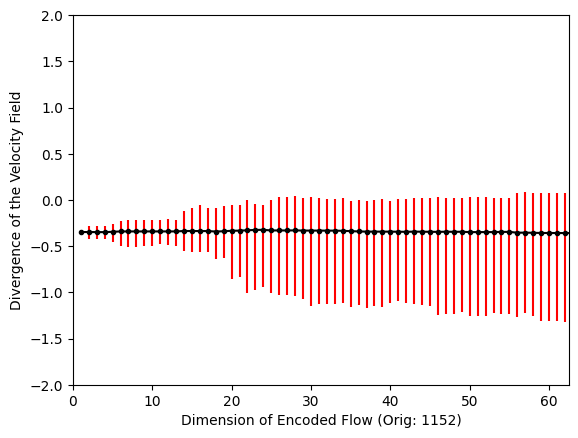

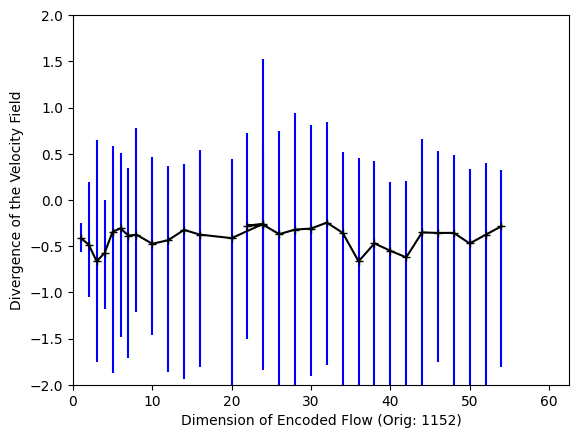

In [33]:
import numpy as np

y_err_below = np.abs(np.array(data_POD['div_max'])-np.array(data_POD['div_avg']))
y_err_above = np.array(data_POD['div_avg'])-np.array(data_POD['div_min'])
plt.errorbar(data_POD['n'], data_POD['div_avg'], [y_err_above, y_err_below],
             label='POD', color='black', ecolor='r', marker='.')

plt.ylabel('Divergence of the Velocity Field')
plt.ylim(top=2, bottom=-2)

plt.xlabel('Dimension of Encoded Flow (Orig: 1152)')
plt.xlim(left=0, right=62.5)

plt.show()

y_err_below = np.abs(np.array(data_AE['div_max']) - np.array(data_AE['div_avg']))
y_err_above = np.array(data_AE['div_avg']) - np.array(data_AE['div_min'])
plt.errorbar(data_AE['n'], data_AE['div_avg'], [y_err_above, y_err_below],
             label='AE', color='black', ecolor='b', marker='+')

plt.ylabel('Divergence of the Velocity Field')
plt.ylim(top=2, bottom=-2)

plt.xlabel('Dimension of Encoded Flow (Orig: 1152)')
plt.xlim(left=0, right=62.5)

plt.show()